In [24]:
from datasets import load_dataset
import pandas as pd
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import email
from email.parser import Parser
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
import matplotlib.ticker as ticker
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
import textstat
from textblob import TextBlob
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

ModuleNotFoundError: No module named 'textstat'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
data = load_dataset("zefang-liu/phishing-email-dataset")

df = data['train'].to_pandas()

print(df.head())
print(df.info)
print(df.shape)
print(df.columns)

   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  
<bound method DataFrame.info of        Unnamed: 0                                         Email Text  \
0               0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1               1  the other side of * galicismos * * galicismo *...   
2               2  re : equistar deal tickets are you still avail...   
3               3  \nHello I am your hot lil horny toy.\n    I am...   
4               4  software at incredibly low prices ( 86 % lower...   
...    

Class distribution

Dataset distribution: 
Safe Email        11322
Phishing Email     7328
Name: Email Type, dtype: int64


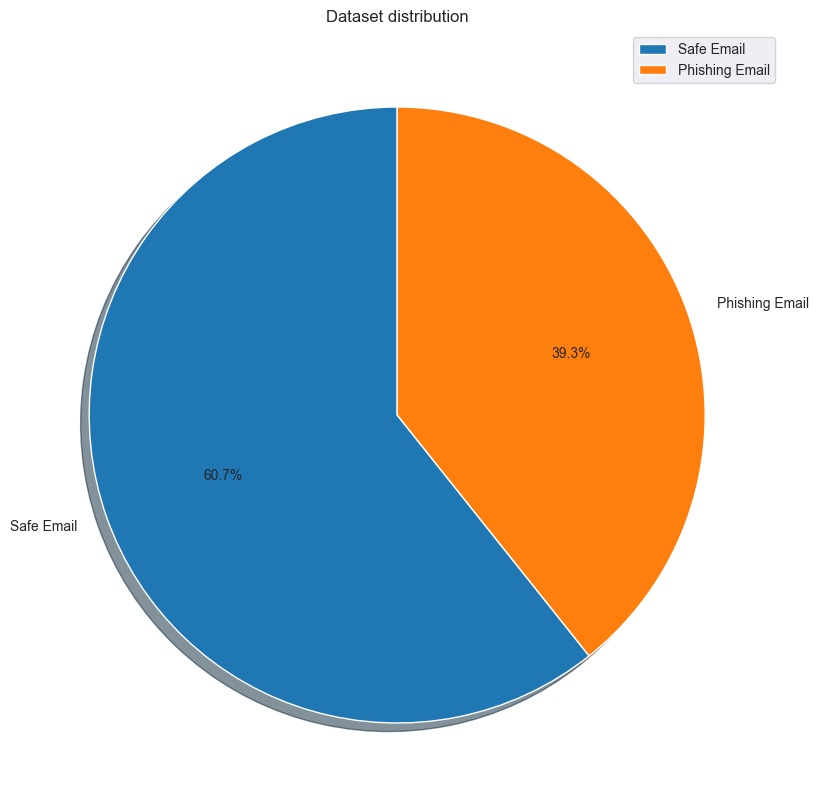

In [4]:
print("Dataset distribution: ")
class_counts = df['Email Type'].value_counts()
print(class_counts)

# Pie chart distribution
plt.figure(figsize=(10, 10))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Dataset distribution')
plt.legend(class_counts.index, loc='best')
plt.show()

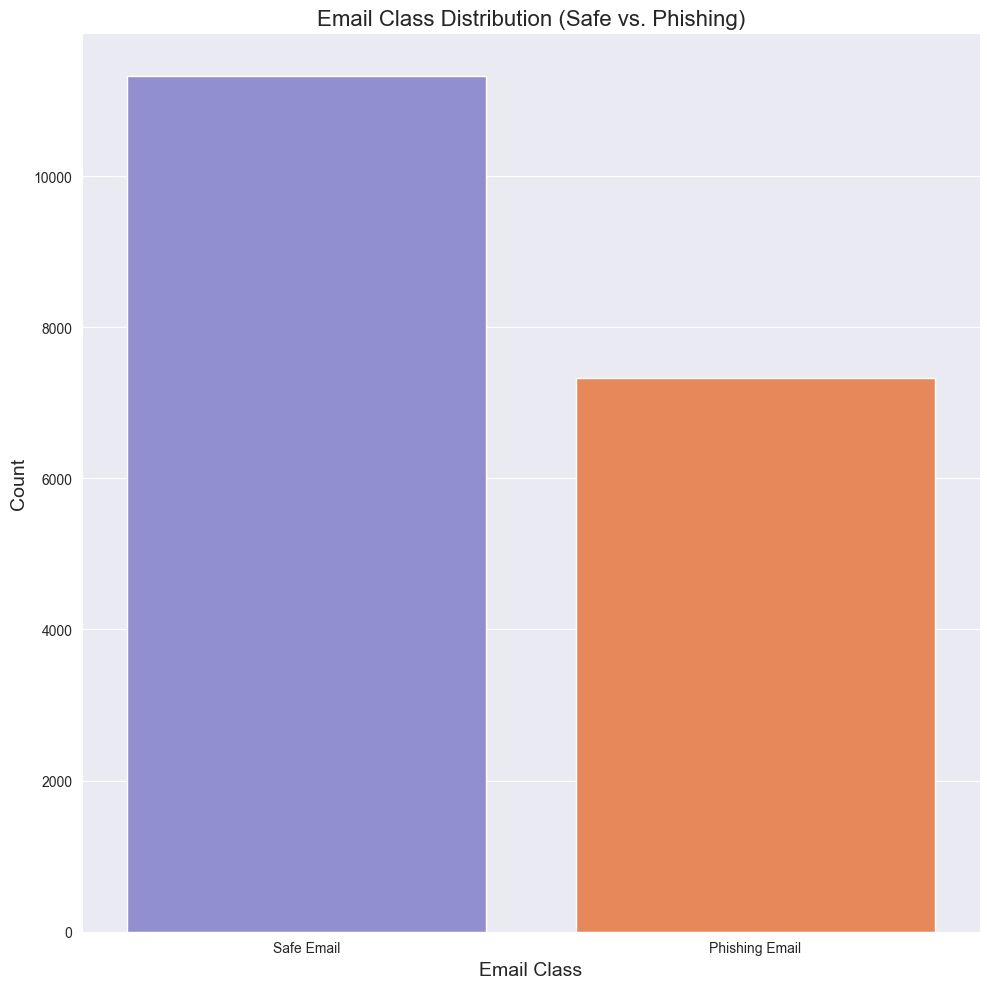

In [8]:
# Bar chart
plt.figure(figsize=(10, 10))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['#8884d8', '#FF8042'])
plt.title('Email Class Distribution (Safe vs. Phishing)', fontsize=16)
plt.xlabel('Email Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()

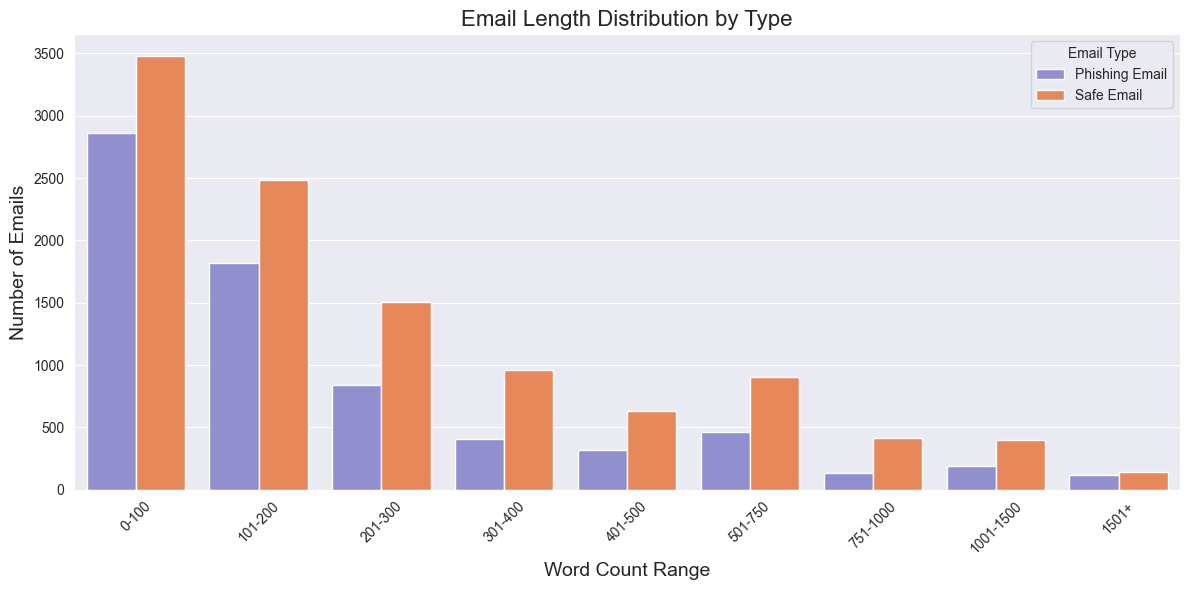

In [13]:
# Create a categorical barplot showing the distribution of email lengths by type
plt.figure(figsize=(12, 6))

# Create bins for word counts
bins = [0, 100, 200, 300, 400, 500, 750, 1000, 1500, 2000]
labels = ['0-100', '101-200', '201-300', '301-400', '401-500', '501-750', '751-1000', '1001-1500', '1501+']

# Add a categorical column for word count ranges
df['word_count_range'] = pd.cut(df['word_count'], bins=bins, labels=labels)

# Create the plot
count_data = df.groupby(['Email Type', 'word_count_range']).size().reset_index(name='count')
sns.barplot(data=count_data, x='word_count_range', y='count', hue='Email Type', palette=['#8884d8', '#FF8042'])

plt.title('Email Length Distribution by Type', fontsize=16)
plt.xlabel('Word Count Range', fontsize=14)
plt.ylabel('Number of Emails', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Email Type')
plt.tight_layout()
plt.show()

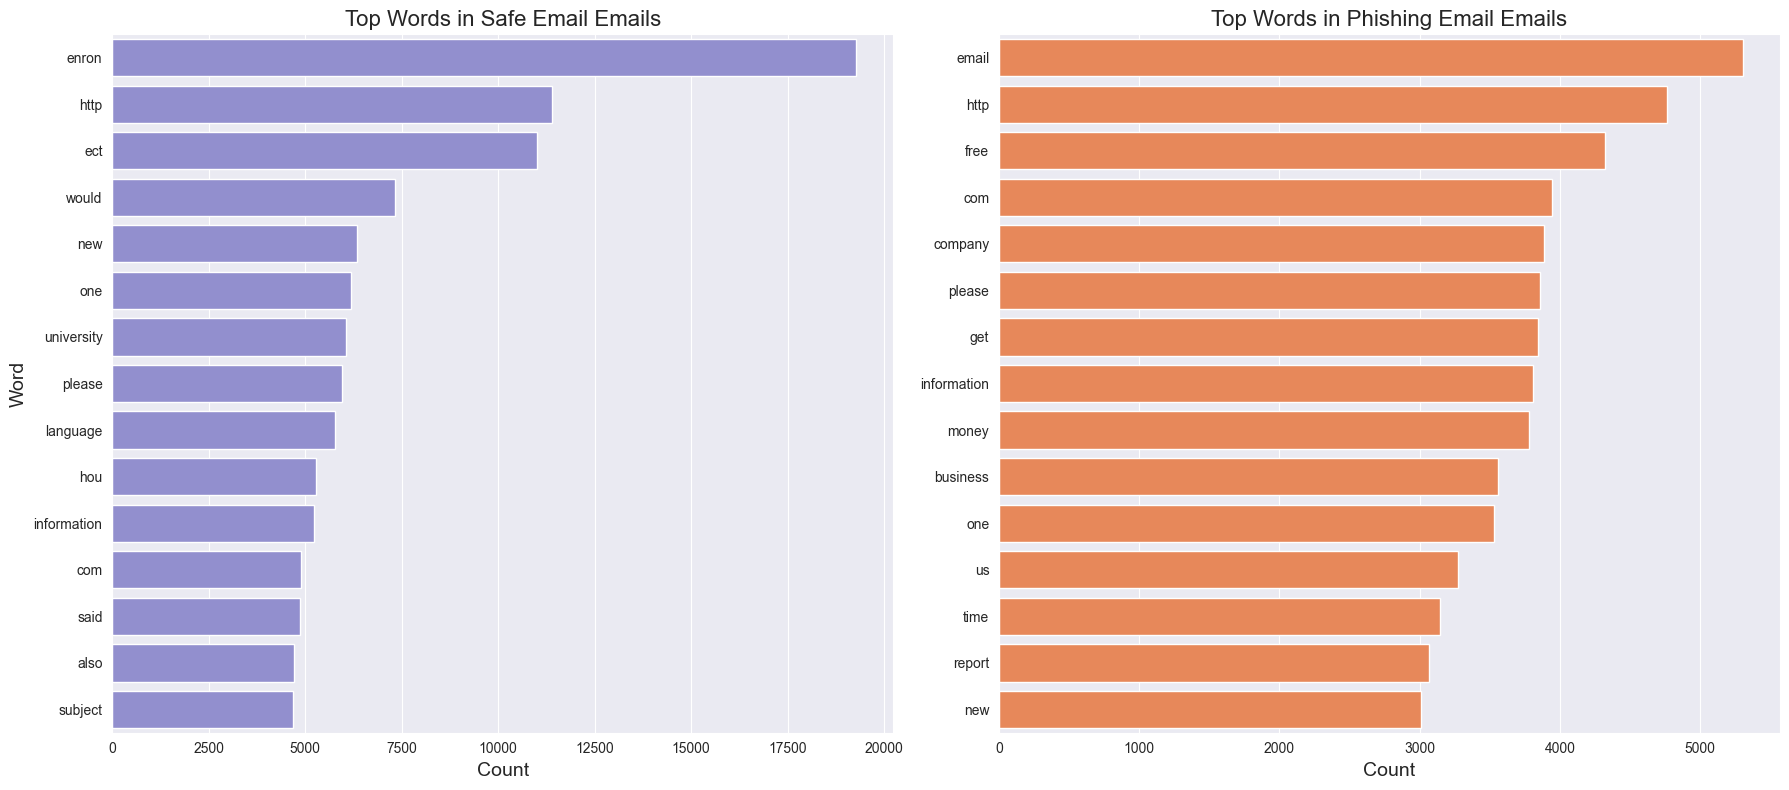

In [14]:
# Function to preprocess and extract words
def extract_words(text, remove_stopwords=True):
    # Getting exact content from raw email
    content = extract_email_content(text)

    # Convert to lowercase and tokenize
    tokens = word_tokenize(content.lower())

    # Remove non-alphabetic tokens and single character tokens
    words = [word for word in tokens if word.isalpha() and len(word) > 1]

    # Remove stopwords (as specified in parameters)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

    return words

# Add tokenized words to dataframe
df['tokens'] = df['Email Text'].apply(extract_words)

# Create word frequency counters for each email type
# Assuming your types might be "ham" and "phishing" instead of "ham" and "spam"
type1_words = Counter()
type2_words = Counter()

# Get the unique email types from your dataset
email_types = df['Email Type'].unique()
type1 = email_types[0]  # First type (e.g., "ham" or "legitimate")
type2 = email_types[1]  # Second type (e.g., "phishing" or "malicious")

# Collect word counts by email type
for idx, row in df.iterrows():
    if row['Email Type'] == type1:
        type1_words.update(row['tokens'])
    else:
        type2_words.update(row['tokens'])

# Get top 15 words for each category
type1_top_words = pd.DataFrame(type1_words.most_common(15), columns=['word', 'count'])
type2_top_words = pd.DataFrame(type2_words.most_common(15), columns=['word', 'count'])

# Create subplots for both email types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot first type words
sns.barplot(x='count', y='word', data=type1_top_words, ax=ax1, color='#8884d8')
ax1.set_title(f'Top Words in {type1} Emails', fontsize=16)
ax1.set_xlabel('Count', fontsize=14)
ax1.set_ylabel('Word', fontsize=14)

# Plot second type words
sns.barplot(x='count', y='word', data=type2_top_words, ax=ax2, color='#FF8042')
ax2.set_title(f'Top Words in {type2} Emails', fontsize=16)
ax2.set_xlabel('Count', fontsize=14)
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

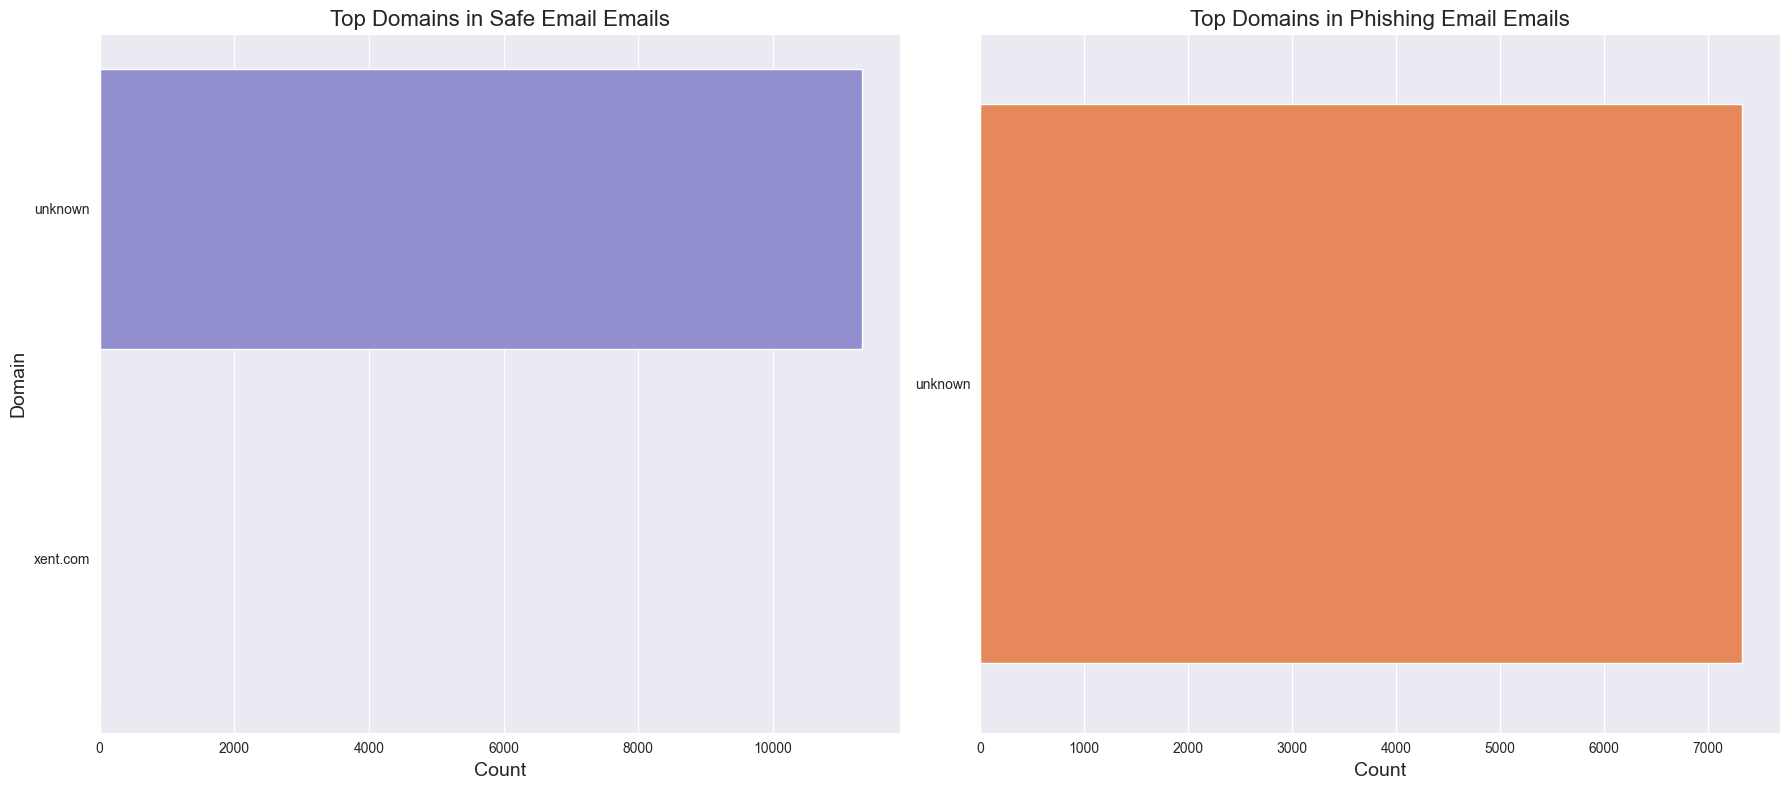

In [15]:
# 5. Sender Domain Analysis
# Function to extract domain from email
def extract_sender_domain(raw_email):
    try:
        # Parse the email
        parsed_email = email.message_from_string(raw_email)

        # Get From header
        from_header = parsed_email.get('From', '')

        # Extract email address
        email_match = re.search(r'[\w\.-]+@([\w\.-]+)', from_header)
        if email_match:
            domain = email_match.group(1).lower()
            return domain
        return 'unknown'
    except Exception:
        return 'unknown'

# Extract sender domains
df['sender_domain'] = df['Email Text'].apply(extract_sender_domain)

# Get the unique email types from your dataset
email_types = df['Email Type'].unique()
type1 = email_types[0]  # First type (e.g., "ham" or "legitimate")
type2 = email_types[1]  # Second type (e.g., "phishing" or "malicious")

# Count domains by email type
type1_domains = Counter(df[df['Email Type'] == type1]['sender_domain'])
type2_domains = Counter(df[df['Email Type'] == type2]['sender_domain'])

# Get top 10 domains for each category
type1_top_domains = pd.DataFrame(type1_domains.most_common(10), columns=['domain', 'count'])
type2_top_domains = pd.DataFrame(type2_domains.most_common(10), columns=['domain', 'count'])

# Create subplots for domain analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot first type domains
sns.barplot(x='count', y='domain', data=type1_top_domains, ax=ax1, color='#8884d8')
ax1.set_title(f'Top Domains in {type1} Emails', fontsize=16)
ax1.set_xlabel('Count', fontsize=14)
ax1.set_ylabel('Domain', fontsize=14)

# Plot second type domains
sns.barplot(x='count', y='domain', data=type2_top_domains, ax=ax2, color='#FF8042')
ax2.set_title(f'Top Domains in {type2} Emails', fontsize=16)
ax2.set_xlabel('Count', fontsize=14)
ax2.set_ylabel('')  # No y-label needed for second plot

plt.tight_layout()
plt.show()